In [1]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 MB 17.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-4.0.0-py2.py3-none-any.whl size=434741299 sha256=59ce3f1ca21156e521fd1d01ff0c9e0dfaa4c9751bb8af3e6efaf5e948dbb6bd
  Stored in directory: /home/codespace/.cache/pip/wheels/2d/77/9b/12660be70f7f447940a0caede37ae208b2e0d1c8487dce52a6
Successfully built pyspark

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!unzip data/housing.csv.zip

Archive:  data/housing.csv.zip
  inflating: housing.csv             


In [9]:
from pyspark.sql import SparkSession, functions as F, types as T
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession.builder.appName('housing').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/14 21:14:16 WARN Utils: Your hostname, codespaces-32ce45, resolves to a loopback address: 127.0.0.1; using 10.0.1.62 instead (on interface eth0)
25/06/14 21:14:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/14 21:14:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [24]:
train = spark.read.csv('housing.csv', header = True)

In [8]:
train.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [25]:
for col in train.columns:
    if col != 'ocean_proximity':
        train = train.withColumn(col, F.col(col).cast(T.FloatType()))

In [10]:
labelCol = 'median_house_value'

In [58]:
def plot_dist(df, col, bin_size):

    df= df.withColumn(f'{col}_bin', (F.col(col) / bin_size).cast(T.IntegerType()) )
    summary = df.groupby(f'{col}_bin').agg(F.count(F.lit(1)).alias('count'), F.avg(labelCol).alias(labelCol)).toPandas()

    fig, ax1 = plt.subplots()

    ax1.bar(summary[f'{col}_bin'] , summary['count'])

    ax2 = ax1.twinx()

    ax2.scatter(summary[f'{col}_bin'] , summary[labelCol], color='red', marker='o', label='Median Value')



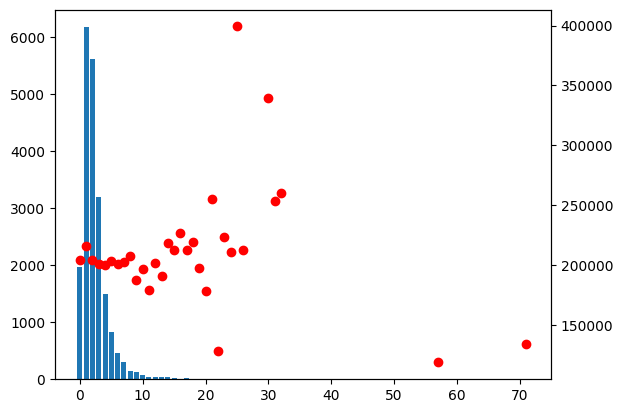

In [59]:
plot_dist(train, 'population', 500)

In [22]:
train.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [26]:
train.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970444871473|35.63186143109965|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710030346416|206855.81690891474|           NULL|
| stddev|  2.0035317

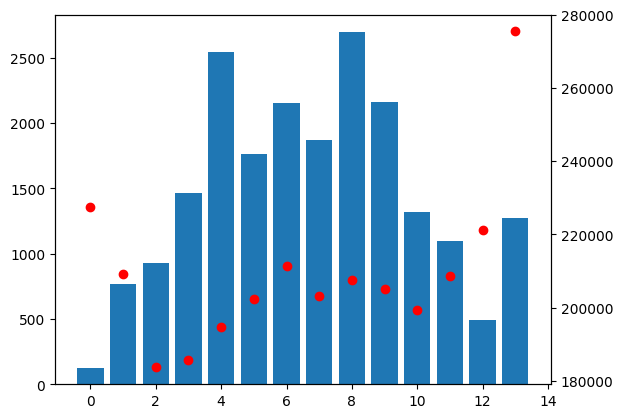

In [60]:
plot_dist(train, 'housing_median_age', 4)

In [41]:
train.dtypes

[('longitude', 'float'),
 ('latitude', 'float'),
 ('housing_median_age', 'float'),
 ('total_rooms', 'float'),
 ('total_bedrooms', 'float'),
 ('population', 'float'),
 ('households', 'float'),
 ('median_income', 'float'),
 ('median_house_value', 'float'),
 ('ocean_proximity', 'string')]

In [47]:
data = []
for col1 in train.columns:
    tmp = []
    for col2 in train.columns:
        if col1 != 'ocean_proximity' and col2 != 'ocean_proximity' : 
            tmp.append(train.corr(col1, col2 ))
    if tmp:            
        data.append(tmp)

In [53]:
import numpy as np
import pandas as pd
corr = pd.DataFrame(data, index = train.columns[:-1], columns = train.columns[:-1])

In [49]:
import seaborn as sns

<Axes: >

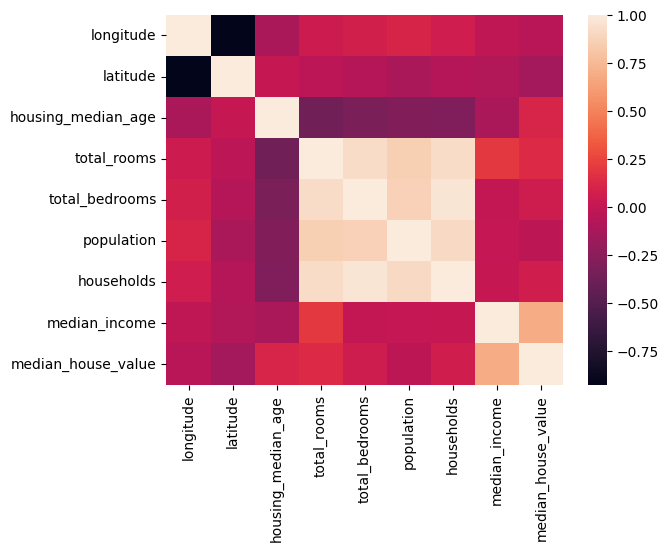

In [54]:
sns.heatmap(corr)

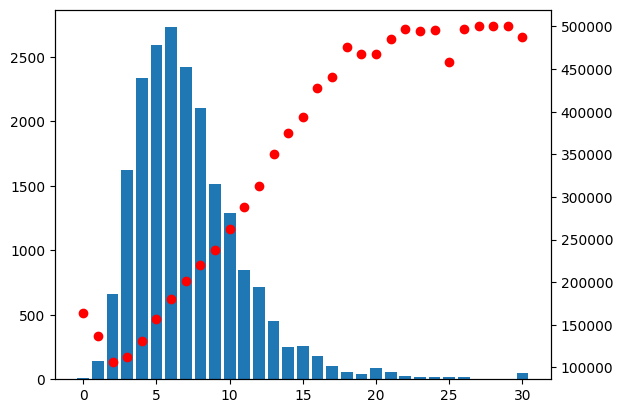

In [61]:
plot_dist(train, 'median_income', bin_size = 0.5)

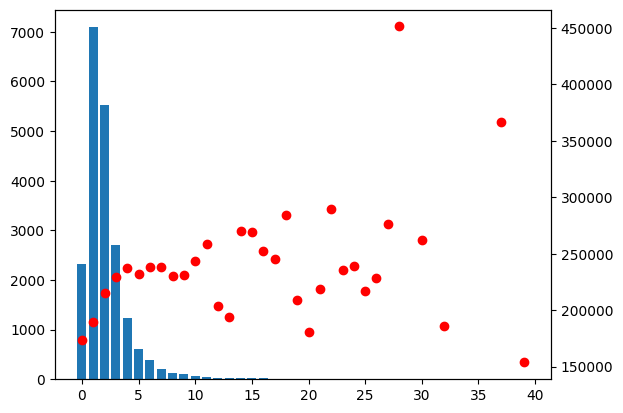

In [65]:
plot_dist(train, 'total_rooms', bin_size = 1000)

In [66]:
train.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [67]:
train = train.withColumn('bedrooms_per_room', F.col('total_bedrooms') / F.col('total_rooms'))
train = train.withColumn('avg_household_size', F.col('population') / F.col('households'))
train = train.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))

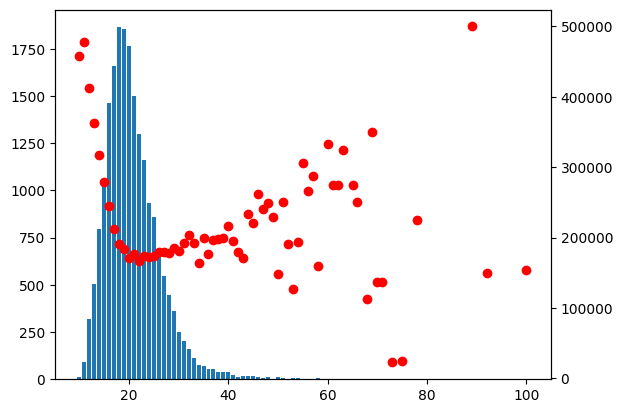

In [75]:
plot_dist(train, 'bedrooms_per_room', bin_size = 0.01)

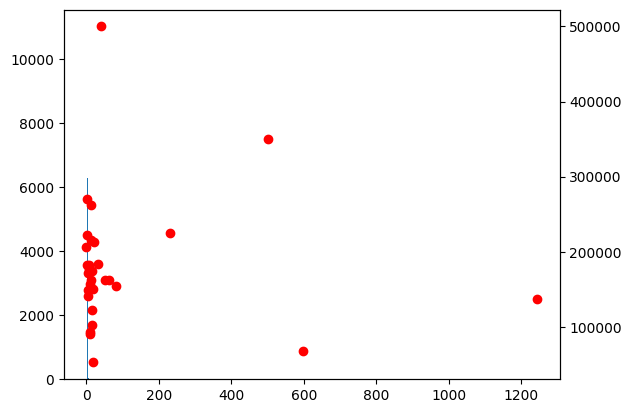

In [80]:
plot_dist(train, 'avg_household_size', bin_size = 1)

In [81]:
train.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+-------------------+------------------+-------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|  bedrooms_per_room|avg_household_size|rooms_per_household|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+-------------------+------------------+-------------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|              20433|             20640| 